# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
---
In this project I used OpenCV, NumPy and Jupyter Notebook road lanes detection.

---

### ** Here are my steps for completeing this project **

This is a long explanation of all steps in order.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


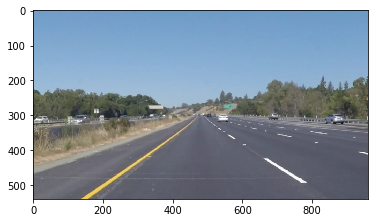

In [2]:
# try reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Developing Pipeline

### Some helper functions
---
I put all of them in one place and kept adding during try/fix iterations while building my pipeline.

In [3]:
def grayscale(img):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def image_to_hsv(img):
    """Convert image to HSV color space"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def image_to_hls(img):
    """Convert image to HSL color space"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def yellow_white_masks(img):
    """
    Applies mask for detecting yellow and white pixels along lane lines
    Input: image converted to HSL color space
    """ 
    # find white lane
    lower_white = np.array([0, 190, 0], dtype=np.uint8)
    upper_white = np.array([180, 255, 255], dtype=np.uint8)
    white_mask = cv2.inRange(img, lower_white, upper_white)
    
    # find yellow lane
    lower_yellow = np.array([0, 70, 100], dtype=np.uint8)
    upper_yellow = np.array([100, 250, 255], dtype=np.uint8)
    yellow_mask = cv2.inRange(img, lower_yellow, upper_yellow)
    
    # combine yellow and white
    yell_white = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(img, img, mask=yell_white)
    return masked

def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def find_vertices(imshape):
    """Find vertices for region of interest"""
    bottom_left = (0, imshape[0])
    bottom_right = (imshape[1], imshape[0])
    top_left = ((imshape[1]/2 - imshape[1]*0.03), imshape[0]/1.6)
    top_right = ((imshape[1]/2 + imshape[1]*0.03), imshape[0]/1.6)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def lines_filter(lines):
    """
    Define all lines that belong to lanes and
    record parameters such as slope and intercept
    Right lines: slope < 0
    Left lines:  slope > 0 
    """
    right_line_parameters = []
    left_line_parameters = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1==x2 or y1==y2:
                continue
            slope  = ((y2-y1)/(x2-x1))
            intercept = y1 - slope*x1
            if slope > 0:
                left_line_parameters.append([slope, intercept])
            if slope < 0:
                right_line_parameters.append([slope, intercept])
    
    right_slope_intercept = np.mean(right_line_parameters, axis=0)
    left_slope_intercept = np.mean(left_line_parameters, axis=0)
    return right_slope_intercept, left_slope_intercept

def line_endpoints(shape, slope_intercept):
    """Calculate (x1, y1), (x2, y2) for a given slope/intercept of a line"""
    # check if some missing values (no line detected)
    try:
        slope = slope_intercept[0]
        intercept = slope_intercept[1]
    except:
        return None
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    # convert to int in order to pass to cv2.line() that accepts only ints
    y1 = int(shape[0])
    x1 = int((y1 - intercept)/slope)
    y2 = int(shape[0]/1.6)
    x2 = int((y2 - intercept)/slope)
    return np.array([[x1, y1, x2, y2]])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.   
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,\
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def two_hough_lines(img, rho=1, theta=np.pi/180, threshold=40, min_line_len=40, max_line_gap=250):
    """
    `img` should be the output of a Canny transform.
    Returns an image with a single line per lane drawn.
    """
    # hough transform
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,\
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # calculate average left and right slope/intercept in order to draw a single line for each lane
    right_slope_intercept, left_slope_intercept = lines_filter(lines)
    
    # find endopints for lines to draw 
    shape = img.shape
    right_line = line_endpoints(shape, right_slope_intercept)
    left_line = line_endpoints(shape, left_slope_intercept)
    two_lines = [right_line, left_line]
    
    # draw lines
    color = [255, 0, 0]
    thickness = 10
    for line in two_lines:
        # check if some missing values (no line detected)
        try:
            for x1,y1,x2,y2 in line:
                cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
        except:
            continue
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Test Images

Building a pipeline to work on the images in the directory "test_images".

In [4]:
import os

# making a list of test images in order to track changes not only for one but for a few images
test_imgs = os.listdir("test_images/")
print("Number of test images: ", len(test_imgs))
os.listdir("test_images/")

Number of test images:  8


['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowChallenge.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidYellowLightChallenge.jpg',
 'whiteCarLaneSwitch.jpg']

### First, let's test color detection

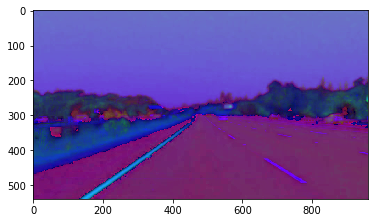

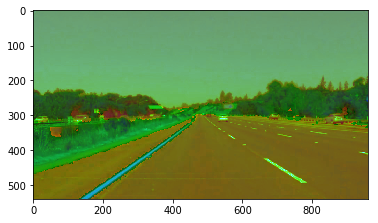

In [5]:
# convert image from RGB to HSL and HSV to decide which one is better for detecting yellow lines
hsv_img = image_to_hsv(image)
hls_img = image_to_hls(image)

hsv_hls = [hsv_img, hls_img]
for img in hsv_hls:
    plt.figure()
    plt.imshow(img)

**HLS color space seems a better choise
Since my pipeline depends on correct color segmentation I'd go with HLS.**

In [6]:
# load all test images for simultaneous tracking
def load_image(img):
    image = mpimg.imread('test_images/{}'.format(img))
    return image

all_test = []
for img in test_imgs:
    image = load_image(img)
    all_test.append(image)

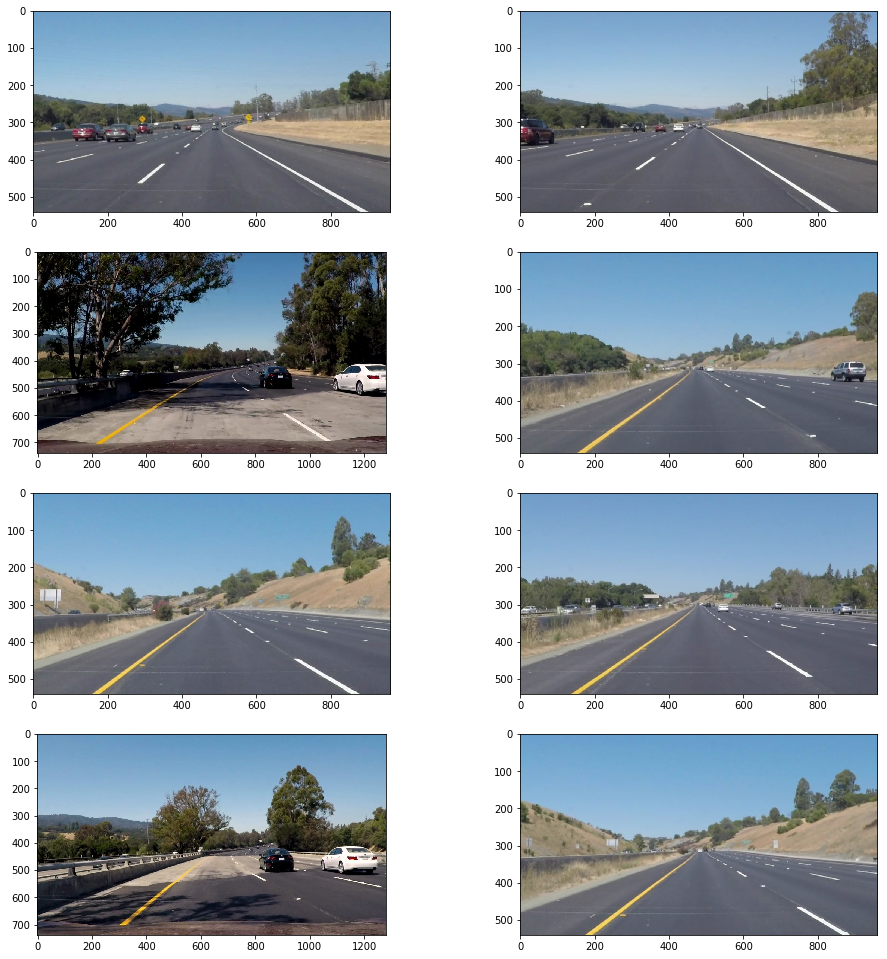

In [7]:
# define a helper function for displaying test images
def show_img(img, cmap=None):
    cols = 2
    rows = (len(img)+1)//cols
    plt.figure(figsize=(16, 17))
    for i, image in enumerate(img):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap=cmap)
    plt.show()
    
show_img(all_test)

In [8]:
# save images
def save_img(img, attr):
    for name, pic in zip(test_imgs, img):
        if len(pic.shape) > 2:
            pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
        cv2.imwrite('test_images_output/{} {}'.format(attr, name), pic)

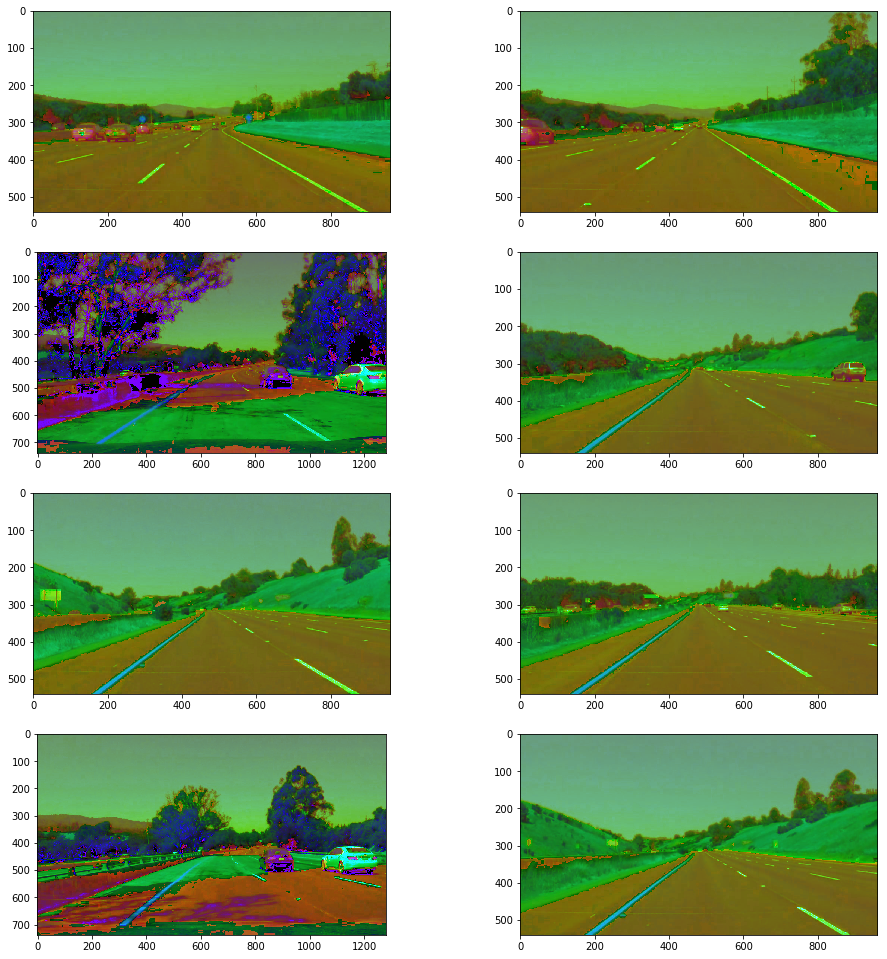

In [9]:
# convert test images to HLS color space
hls_test = [image_to_hls(img) for img in all_test]
show_img(hls_test)
save_img(hls_test, 'hls')

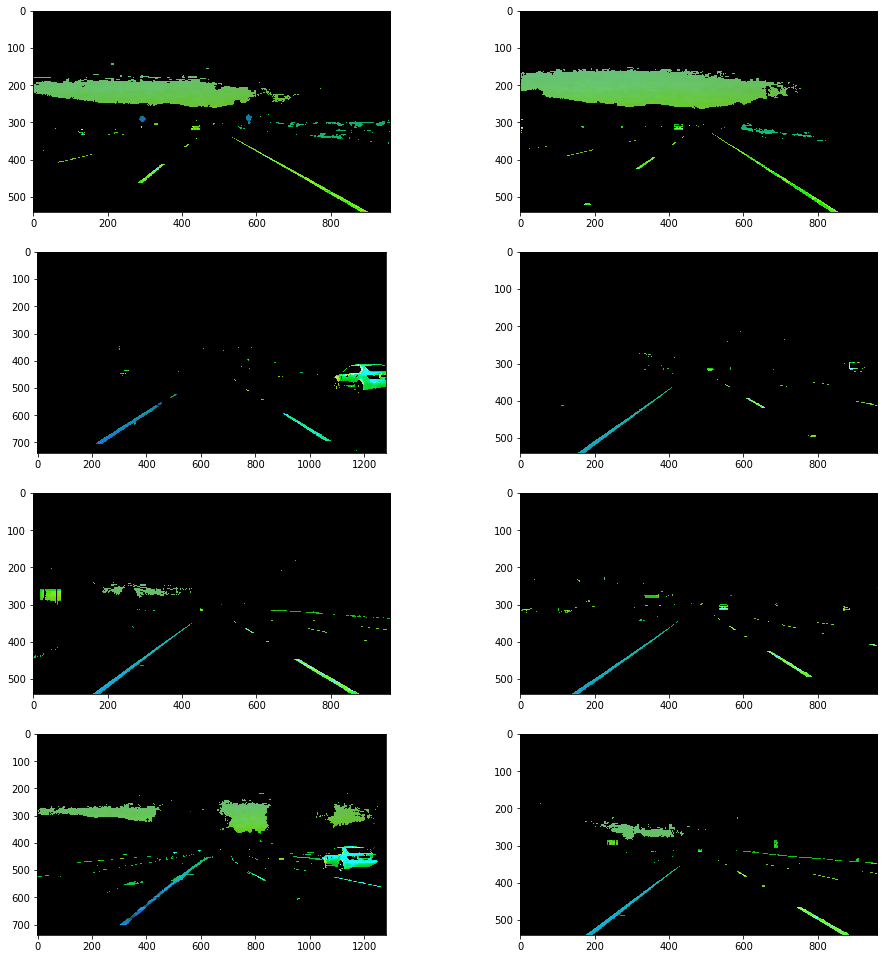

In [10]:
# detect yellow and white lanes lines using smart masking
# now we can see white and yellow lines clearly
masked_test = [yellow_white_masks(img) for img in hls_test]
show_img(masked_test)
save_img(masked_test, 'masked')

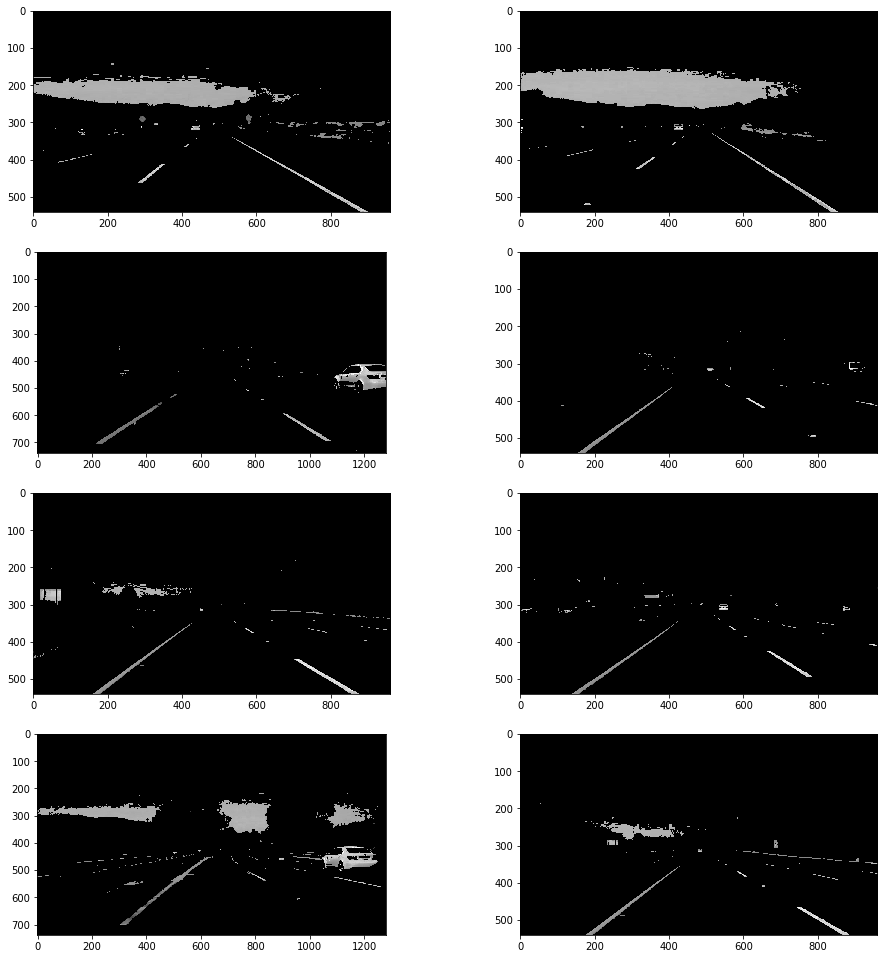

In [11]:
# next step
# convert masked images to grayscale
gray_test = [grayscale(img) for img in masked_test]
show_img(gray_test, cmap="gray")
save_img(gray_test, 'gray')

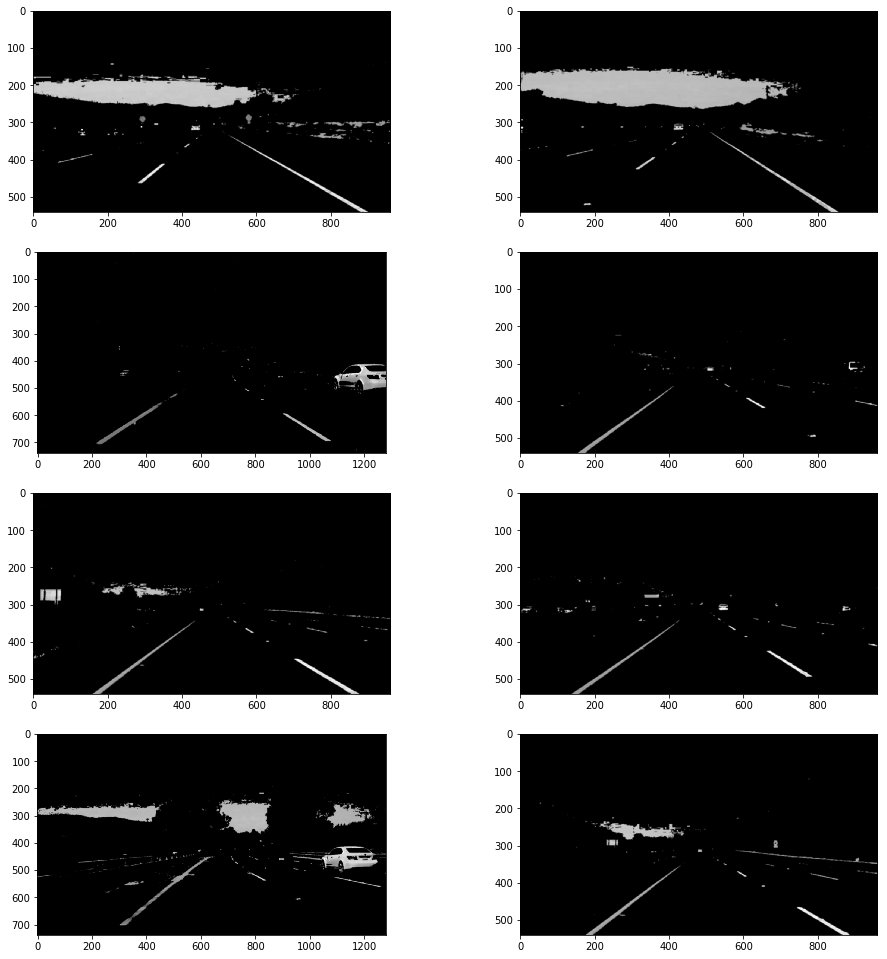

In [12]:
# use gaussian blur to prepare images for edge detection
kernel_size = 5
blur_test = [gaussian_blur(img, kernel_size) for img in gray_test]
show_img(blur_test, cmap="gray")
save_img(blur_test, 'blur')

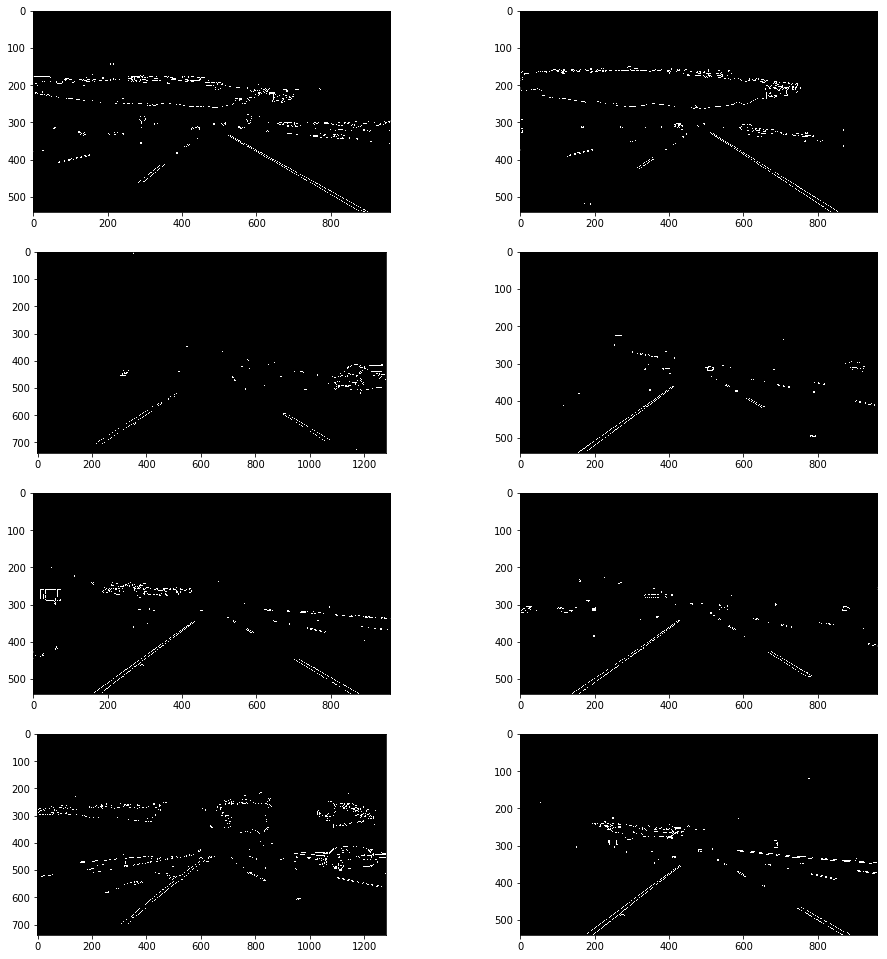

In [13]:
# use canny edge detection filter
low_threshold = 50
high_threshold = 150
edge_test = [canny(img, low_threshold, high_threshold) for img in blur_test]
show_img(edge_test, cmap="gray")
save_img(edge_test, 'edge')

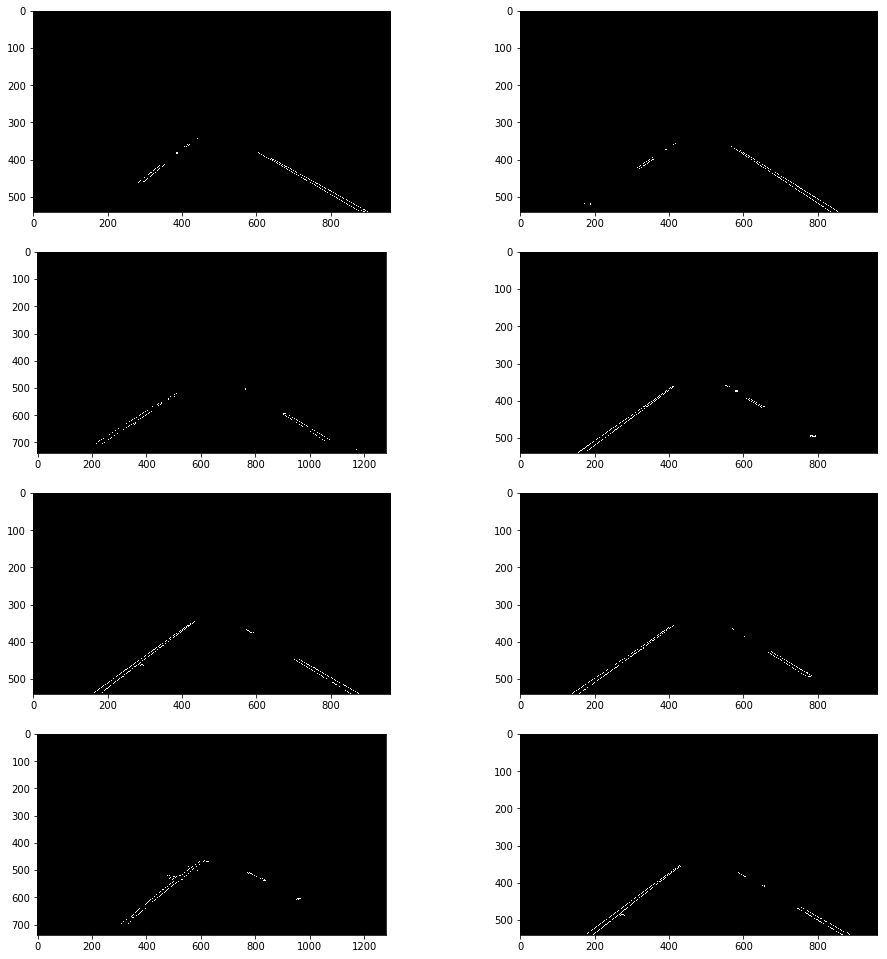

In [14]:
# define region of interest
# first, find vertices of the region of interest 
imshape_test = [img.shape for img in edge_test]
vertices_test = [find_vertices(imshape) for imshape in imshape_test]

region_of_interest_test = [region_of_interest(img, vertices) for img, vertices in zip(edge_test, vertices_test)]
show_img(region_of_interest_test, cmap="gray")
save_img(region_of_interest_test, 'roi')

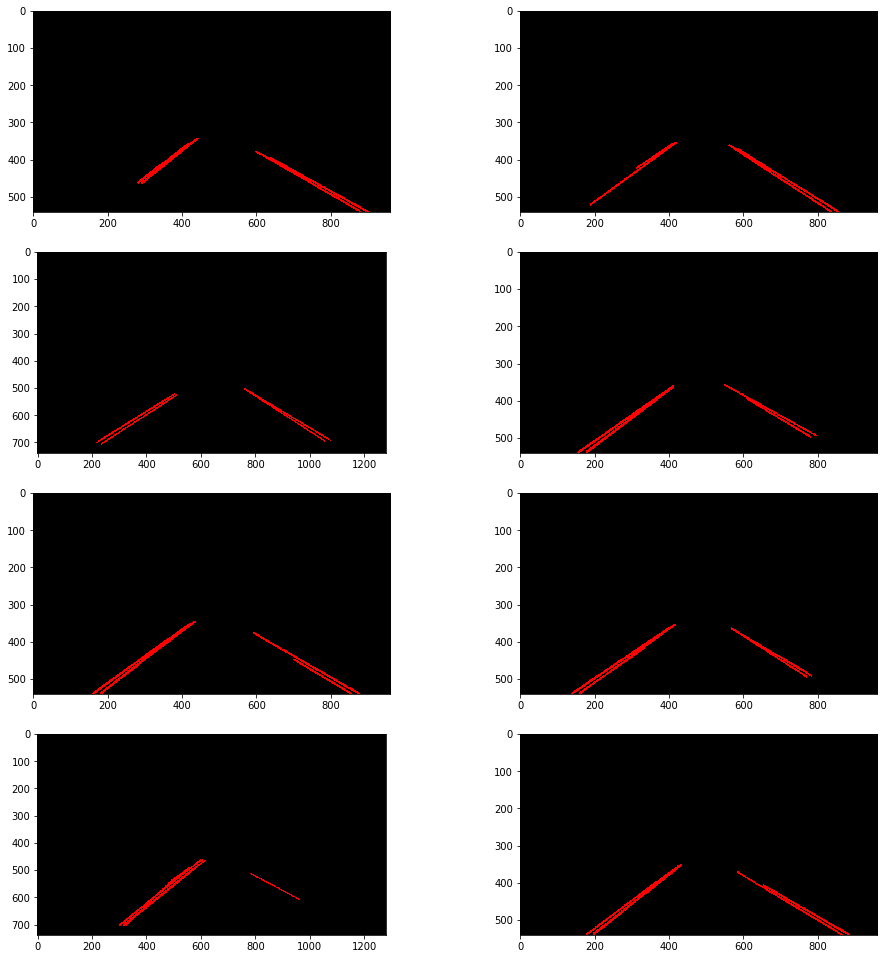

In [15]:
# next: hough transform and draw lines
rho = 1                       # distance resolution in pixels of the Hough grid
theta = np.pi/180             # angular resolution in radians of the Hough grid
threshold = 40                # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40             # minimum number of pixels making up a line
max_line_gap = 200            # maximum gap in pixels between connectable line segments

lines_test = [hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap) for img in region_of_interest_test]
show_img(lines_test)
save_img(lines_test, 'lines')

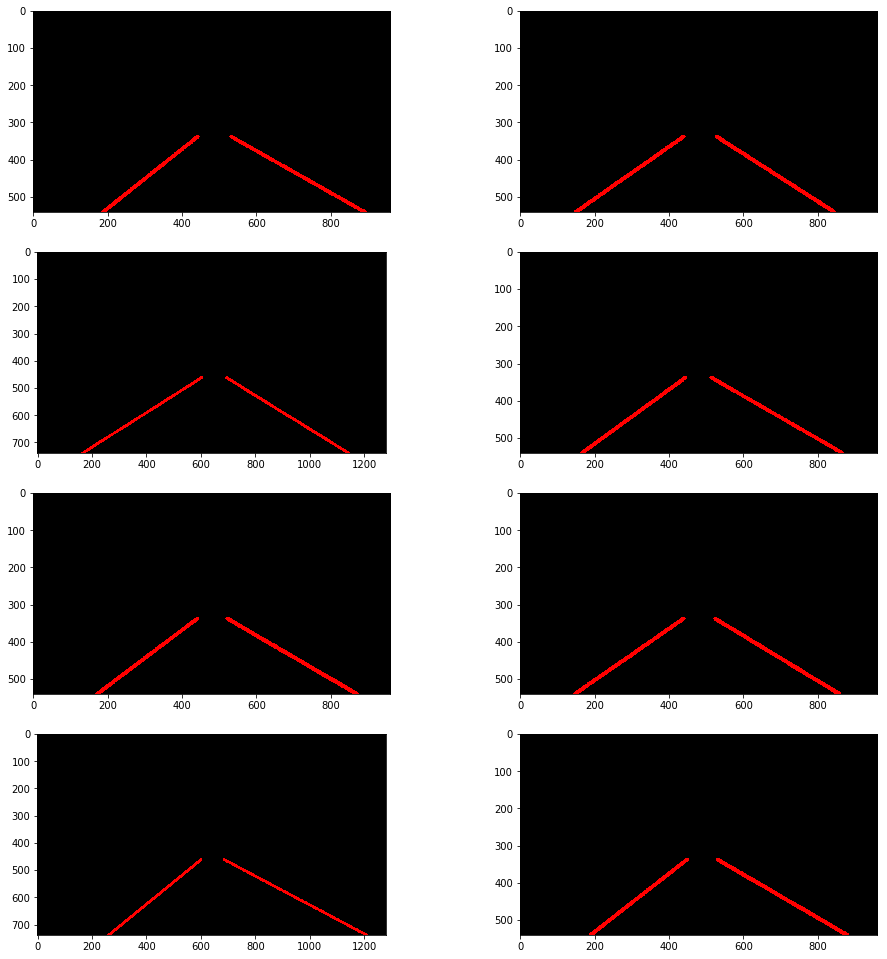

In [16]:
# let's show just a single line per detected lane
two_lines_test = [two_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)\
                  for img in region_of_interest_test]
show_img(two_lines_test)
save_img(two_lines_test, 'two_lines')

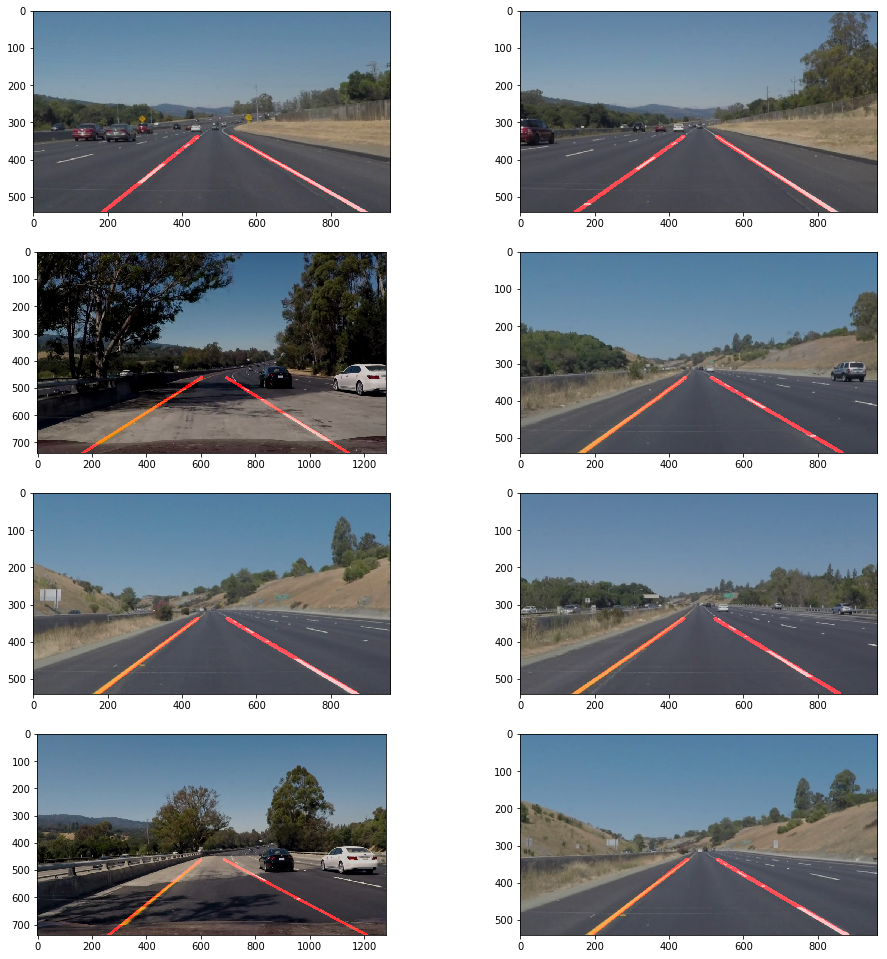

In [17]:
# initial image and lines combined
result_test = [weighted_img(img, initial_img) for img, initial_img in zip(two_lines_test, all_test)]
show_img(result_test)
save_img(result_test, 'result')

## Test on Videos

Now, when pipeline seems working, we can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(image):
    hls       = image_to_hls(image)
    masked    = yellow_white_masks(hls)
    gray      = grayscale(masked)
    blur      = gaussian_blur(gray)
    edges     = canny(blur)
    vertices  = find_vertices(image.shape)
    roi       = region_of_interest(edges, vertices)
    two_lines = two_hough_lines(roi)
    result    = weighted_img(two_lines, image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [20]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 29.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.58 s, sys: 591 ms, total: 5.17 s
Wall time: 8.43 s


Play the video inline.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:23<00:00, 30.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 14.2 s, sys: 1.85 s, total: 16 s
Wall time: 24 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Improve the pipeline!

**At this point, the pipeline works. However, we can see clearly that there is some jittering and some missing frames.**

I put all functions in the pipeline into a class. This allows us to have a convinient way to represent given pipeline as well as add some helpful features such as buffering. Buffering helps us to fill missing frames with averaged approximation and get rid of jittering lines.

In [24]:
from collections import deque # this makes buffer of constant length and automatically keeps it updated
                              # deleting first item in the list

class LaneTracker:
    def __init__(self):
        # for unified size
        self.width           = 960
        self.height          = 540
        # for canny edges
        self.low_threshold   = 50
        self.high_threshold  = 150
        # for blurring/smoothing
        self.kernel_size     = 5
        # for hough lines
        self.rho             = 1
        self.theta           = np.pi/180
        self.threshold       = 40
        self.min_line_len    = 40
        self.max_line_gap    = 250
        # for avoiding outliers
        self.min_left_slope  = 0.5
        self.max_left_slope  = 0.7
        self.min_right_slope = -0.9
        self.max_right_slope = -0.5
        # for filling the gaps
        self.buffer_left          = deque(maxlen=5)
        self.buffer_right         = deque(maxlen=5)
    
    def resize(self, img):
        return cv2.resize(img,(self.width, self.height), interpolation = cv2.INTER_LINEAR)
        
    def yellow_white_masks(self, img):
        # convert to HSL
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        # find white lane
        lower_white = np.array([0, 190, 0], dtype=np.uint8)
        upper_white = np.array([180, 255, 255], dtype=np.uint8)
        white_mask = cv2.inRange(img, lower_white, upper_white)
        # find yellow lane
        lower_yellow = np.array([0, 70, 100], dtype=np.uint8)
        upper_yellow = np.array([100, 250, 255], dtype=np.uint8)
        yellow_mask = cv2.inRange(img, lower_yellow, upper_yellow)
        # combine yellow and white
        yell_white = cv2.bitwise_or(white_mask, yellow_mask)
        masked = cv2.bitwise_and(img, img, mask=yell_white)
        return masked
    
    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    def gaussian_blur(self, img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    def canny(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

    def find_vertices(self, imshape):
        bottom_left = (0, imshape[0])
        bottom_right = (imshape[1], imshape[0])
        top_left = ((imshape[1]/2 - imshape[1]*0.03), imshape[0]/1.6)
        top_right = ((imshape[1]/2 + imshape[1]*0.03), imshape[0]/1.6)
        vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
        return vertices
    
    def region_of_interest(self, img):
        vertices  = self.find_vertices(img.shape)
        #defining a blank mask to start with
        mask = np.zeros_like(img)   
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        #filling pixels inside the polygon defined by vertices with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
    
    def lines_filter(self, lines):
        # Right lines: slope < 0; Left lines:  slope > 0 
        right_line_parameters = []
        left_line_parameters = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                if x1==x2 or y1==y2:
                    continue
                slope  = ((y2-y1)/(x2-x1))
                intercept = y1 - slope*x1
                # initalizing slope control and keep only lines of interest
                if slope > 0 and slope > self.min_left_slope and slope < self.max_left_slope:
                    left_line_parameters.append([slope, intercept])
                if slope < 0 and slope > self.min_right_slope and slope < self.max_right_slope:
                    right_line_parameters.append([slope, intercept])
        # average parameters to form only one line per detected lane
        right_slope_intercept = np.mean(right_line_parameters, axis=0)
        left_slope_intercept = np.mean(left_line_parameters, axis=0)
        return right_slope_intercept, left_slope_intercept

    def line_endpoints(self, shape, slope_intercept):
        # check if some missing values (meaning no line detected)
        try:
            slope = slope_intercept[0]
            intercept = slope_intercept[1]
        except:
            return None
        
        slope = slope_intercept[0]
        intercept = slope_intercept[1]
        y1 = int(shape[0])
        x1 = int((y1 - intercept)/slope)
        y2 = int(shape[0]/1.6)
        x2 = int((y2 - intercept)/slope)
        return [x1, y1, x2, y2]

    def two_hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        # hough transform
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                                maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        # calculate average left and right slope/intercept in order to draw a single line for each lane
        right_slope_intercept, left_slope_intercept = self.lines_filter(lines)
        # find endopints for lines to draw 
        shape = img.shape
        right_line = self.line_endpoints(shape, right_slope_intercept)
        left_line = self.line_endpoints(shape, left_slope_intercept)
        # check if lines detected successfully
        if right_line is None:
            if self.buffer_right:
                right_line = np.mean(self.buffer_right, axis=0, dtype=np.uint32)
        if left_line is None:
            if self.buffer_left:
                left_line = np.mean(self.buffer_left, axis=0, dtype=np.uint32)
        else:
            self.buffer_right.append(right_line)
            self.buffer_left.append(left_line)
            right_line = np.mean(self.buffer_right, axis=0, dtype=np.uint32)
            left_line = np.mean(self.buffer_left, axis=0, dtype=np.uint32)
        # draw lines
        two_lines = [right_line, left_line]
        color = [255, 0, 0]
        thickness = 10
        for line in two_lines:
            cv2.line(line_img, (line[0], line[1]), (line[2], line[3]), color, thickness)
        return line_img

    def weighted_img(self, img, initial_img, α=0.8, β=1., λ=0.):
        return cv2.addWeighted(initial_img, α, img, β, λ)

    def process_image(self, image):
        if image.shape[0] > 540 and image.shape[1] > 960:
            image     = self.resize(image)
        masked    = self.yellow_white_masks(image)
        gray      = self.grayscale(masked)
        blur      = self.gaussian_blur(gray, self.kernel_size)
        edges     = self.canny(blur, self.low_threshold, self.high_threshold)
        roi       = self.region_of_interest(edges)
        two_lines = self.two_hough_lines(roi, self.rho, self.theta, self.threshold, self.min_line_len, 
                                         self.max_line_gap)
        result    = self.weighted_img(two_lines, image)
        return result

# Now let's try our new class on videos

In [25]:
tracker_white = LaneTracker()
white_out = 'test_videos_output/solidWhiteRightUpgraded.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(tracker_white.process_image)
%time white_clip.write_videofile(white_out, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRightUpgraded.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRightUpgraded.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRightUpgraded.mp4 

CPU times: user 4.61 s, sys: 599 ms, total: 5.2 s
Wall time: 8.64 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_out))

# Aha! Much better

In [27]:
tracker_yellow = LaneTracker()
yellow_out = 'test_videos_output/solidYellowLeftUpgraded.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(tracker_yellow.process_image)
%time yellow_clip.write_videofile(yellow_out, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeftUpgraded.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeftUpgraded.mp4


100%|█████████▉| 681/682 [00:23<00:00, 26.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeftUpgraded.mp4 

CPU times: user 14.5 s, sys: 1.79 s, total: 16.3 s
Wall time: 24.9 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_out))

## And, of course, Challenge video


At first, let's see how first developed simple pipline would perform.


In [29]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:17<00:00, 14.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9.36 s, sys: 2.14 s, total: 11.5 s
Wall time: 20.2 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Now, the upgraded class - "LaneTracker()"

In [31]:
tracker_challenge = LaneTracker()
challenge_out = 'test_videos_output/challengeUpgraded.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip1.fl_image(tracker_challenge.process_image)
%time challenge_clip.write_videofile(challenge_out, audio=False)

[MoviePy] >>>> Building video test_videos_output/challengeUpgraded.mp4
[MoviePy] Writing video test_videos_output/challengeUpgraded.mp4


100%|██████████| 251/251 [00:10<00:00, 23.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challengeUpgraded.mp4 

CPU times: user 7.23 s, sys: 1.33 s, total: 8.56 s
Wall time: 11.6 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_out))

### A Fun Part!

Let's drop hardcoded region of interest and see what we've got.

In [33]:
# add some intercept control along with the slope control
class LaneTrackerNoRoi(LaneTracker):
    def __init__(self):
        # for unified size
        self.width           = 960
        self.height          = 540
        # for canny edges
        self.low_threshold   = 50
        self.high_threshold  = 150
        # for blurring/smoothing
        self.kernel_size     = 5
        # for hough lines
        self.rho             = 1
        self.theta           = np.pi/180
        self.threshold       = 40
        self.min_line_len    = 40
        self.max_line_gap    = 250
        # for avoiding outliers
        self.min_left_slope  = 0.5
        self.max_left_slope  = 0.7
        self.min_right_slope = -0.9
        self.max_right_slope = -0.5
        self.min_left_intercept  = 15
        self.max_left_intercept  = 45
        self.min_right_intercept = 630
        self.max_right_intercept = 690
        # for filling gaps
        self.buffer_left          = deque(maxlen=5)
        self.buffer_right         = deque(maxlen=5)
        
    
    def lines_filter(self, lines):
        # Right lines: slope < 0; Left lines:  slope > 0 
        right_line_parameters = []
        left_line_parameters = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                if x1==x2 or y1==y2:
                    continue
                slope  = ((y2-y1)/(x2-x1))
                intercept = y1 - slope*x1
                if slope > 0 and slope > self.min_left_slope and slope < self.max_left_slope\
                and (intercept > self.min_left_intercept and intercept < self.max_left_intercept):
                    left_line_parameters.append([slope, intercept])
                if slope < 0 and slope > self.min_right_slope and slope < self.max_right_slope\
                and (intercept > self.min_right_intercept and intercept < self.max_right_intercept):
                    right_line_parameters.append([slope, intercept])
        right_slope_intercept = np.mean(right_line_parameters, axis=0)
        left_slope_intercept = np.mean(left_line_parameters, axis=0)
        return right_slope_intercept, left_slope_intercept

    def process_image(self, image):
        if image.shape[0] > 540 and image.shape[1] > 960:
            image     = self.resize(image)
        masked    = self.yellow_white_masks(image)
        gray      = self.grayscale(masked)
        blur      = self.gaussian_blur(gray, self.kernel_size)
        edges     = self.canny(blur, self.low_threshold, self.high_threshold)
        two_lines = self.two_hough_lines(edges, self.rho, self.theta, self.threshold, self.min_line_len, 
                                         self.max_line_gap)
        result    = self.weighted_img(two_lines, image)
        return result

In [34]:
tracker_white_noroi = LaneTrackerNoRoi()
white_out_noroi = 'test_videos_output/solidWhiteRightNoRoi.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip_noroi = clip1.fl_image(tracker_white_noroi.process_image)
%time white_clip_noroi.write_videofile(white_out_noroi, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRightNoRoi.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRightNoRoi.mp4


100%|█████████▉| 221/222 [00:09<00:00, 23.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRightNoRoi.mp4 

CPU times: user 6.92 s, sys: 1.16 s, total: 8.08 s
Wall time: 10.4 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_out_noroi))

In [36]:
tracker_challenge_noroi = LaneTrackerNoRoi()
challenge_out_noroi = 'test_videos_output/challengeNoRoi.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip_noroi = clip1.fl_image(tracker_challenge_noroi.process_image)
%time challenge_clip_noroi.write_videofile(challenge_out_noroi, audio=False)

[MoviePy] >>>> Building video test_videos_output/challengeNoRoi.mp4
[MoviePy] Writing video test_videos_output/challengeNoRoi.mp4


100%|██████████| 251/251 [00:12<00:00, 15.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challengeNoRoi.mp4 

CPU times: user 8.77 s, sys: 1.63 s, total: 10.4 s
Wall time: 13.4 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_out_noroi))